<a href="https://colab.research.google.com/github/sjunc/AI-Library/blob/main/class/W07_CRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAPTCHA 이미지 CRNN 인식

In [4]:
#코랩에서 구글 드라이브의 데이터를 사용할 수 있도록 설정함
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


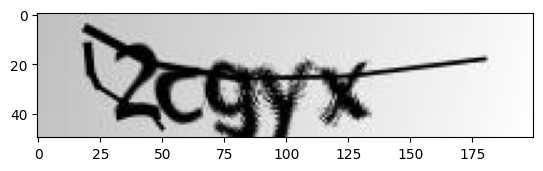

In [5]:
import string

import matplotlib.pyplot as plt
import glob                     # Glob은 파일이나 디렉터리의 경로명을 찾는 모듈이나 함수

import tqdm
from PIL import Image           # 이미지 처리 라이브러리

imgfile = glob.glob(
    "/content/drive/MyDrive/data/CH12/*.png"# *이미지 경로를 알맞게 수정하세요*
    )[0]  #[0]: 첫 번째 이미지 파일만 선택
imgfile = Image.open(imgfile)  # 이미지를 읽어옴

plt.imshow(imgfile)
plt.show()

In [6]:
#학습용 데이터셋 만들기
import numpy as np

from torch.utils.data.dataset import Dataset


# 문자들로부터 BOW(Bag of Words)를 만드는 함수
def get_BOW(corpus):
   # 공백문자 <pad>의 인덱스를 0으로 설정 (패딩용 토큰)
   BOW = {"<pad>":0}

   # corpus의 문자들을 이용해 BOW에 고유번호 추가
   for letter in corpus:
       if letter not in BOW.keys():
           BOW[letter] = len(BOW.keys())

   return BOW


#Captcha 이미지 데이터셋 정의
class Captcha(Dataset):
   def __init__(self, pth, train=True):

       # 소문자와 숫자만 정답으로 이용할 것임
       self.corpus = string.ascii_lowercase + string.digits
       self.BOW = get_BOW(self.corpus)#BOW 사전 생성

       # 경로 내의 모든 png 이미지를 불러오기
       self.imgfiles = glob.glob(pth+"/*.png")

       # 학습용(80%)/시험용(20%) 데이터셋 분할
       self.train = train
       self.trainset = self.imgfiles[:int(len(self.imgfiles)*0.8)]
       self.testset = self.imgfiles[int(len(self.imgfiles)*0.2):]

   # 문자와 숫자를 고유번호(인덱스)로 치환
   def get_seq(self, line):
       label = []

       for letter in line:
           label.append(self.BOW[letter])

       return label

   # 전체 데이터셋의 길이 반환
   def __len__(self):
       if self.train:
           return len(self.trainset)
       else:
           return len(self.testset)

   # 학습용 또는 시험용 이미지와 정답을 1개씩 반환해줌
   # test_img, label = testset[0] 처럼 데이터를 가져와 사용하게 하기 위해 필요한 코드
   def __getitem__(self, i):
       #학습용
       if self.train:
           # png파일을 RGB파일로 변환
           data = Image.open(self.trainset[i]).convert("RGB") #RGB이미지로 변환

           #파일 이름에서 확장자를 제거하여 정답을 추출하는 부분
           label = self.trainset[i].split("/")[-1]
           # 파일이름에서 확장자를 제거
           label = label.split(".png")[0]
           # 정답 문자열을 BOW의 순열로 변환함
           label = self.get_seq(label)

           data = np.array(data).astype(np.float32)
           # 파이토치는 채널이 가장 앞에 와야 함
           data = np.transpose(data, (2, 0, 1))
           label = np.array(label)

           return data, label

       #시험용
       else:
           data = Image.open(self.testset[i]).convert("RGB")
           label = self.testset[i].split("/")[-1]
           label = label.split(".png")[0]
           label = self.get_seq(label)

           data = np.array(data).astype(np.float32)
           label = np.array(label)

           return data, label

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# 3X5 크기의 커널을 이용하는 합성곱층(convolution layer)들을 정의함
class BasicBlock(nn.Module):
   def __init__(self,
                in_channels,# 입력 채널의 수
                out_channels,# 출력 채널의 수
                kernel_size=(3, 5),# convolution layer의 커널 크기 기본값
                stride=(2, 1)):# 첫 번째 convolution layer의 스트라이드 - (가로, 세로)로 몇 칸씩 이동할 것인지
       super(BasicBlock, self).__init__()

       # 첫 번째 합성곱층의 정의
       self.c1 = nn.Conv2d(in_channels=in_channels,
                           out_channels=out_channels,
                           kernel_size=kernel_size,
                           stride=stride)

       # 두 번째 합성곱층의 정의(3*3 커널 사용, padding을 넣어 feature의 크기 유지)
       self.c2 = nn.Conv2d(in_channels=out_channels,
                           out_channels=out_channels,
                           kernel_size=(3, 3), padding=1)

       # 입력 x의 크기 / 채널 수를 맞춰주기 위한 downsample
       self.downsample = nn.Conv2d(in_channels=in_channels,
                                   out_channels=out_channels,
                                   kernel_size=kernel_size,
                                   stride=stride)

       #배치 정규화 1,2 - 학습 속도를 빠르게 내게 하기 위함
       self.bn1 = nn.BatchNorm2d(num_features=out_channels)
       self.bn2 = nn.BatchNorm2d(num_features=out_channels)

       #활성화 함수
       self.relu = nn.ReLU()


   def forward(self, x):
       x_ = x #입력 값을 skip connection용으로 저장(변환없이 바로 전달하기 위함)

       # conv -> batch norm -> relu -> conv -> batch norm 층을 순차적으로 지남
       x = self.c1(x)
       x = self.bn1(x)
       x = self.relu(x)
       x = self.c2(x)
       x = self.bn2(x)

       # 잔차 경로 처리(크기와 채널 수를 맞춘 후 더함)
       x_ = self.downsample(x_)

       # 주 경로와 잔차를 더함(residual connection)
       x += x_
       x = self.relu(x)

       #출력 텐서 반환
       return x

#(생각해보기)
#1. Residual Connection이 왜 필요할까?
   # 신경망이 깊어지면 학습 과정에서 기울기 소실 문제가 발생함
   #  -> 가중치가 제대로 업데이트되지 않음
   #  -> 잔차 연결(Residual connection)을 사용해 입력을 다음 블록의 출력에 그대로 더해주면 기울기 소실 문제를 완화할 수 있음
   #  -> 네트워크를 깊게 쌓아서 생기는 성능 저하 문제를 완화할 수 있게 됨

#2. downsampling이 꼭 필요할까?
   # 꼭 필요하다. Residual Connection을 할 때 블록의 출력과 이전부터 내려온 입력값을 더해주어야 함.
   # 그런데 Block을 거치면서 출력 크기나 채널 수가 변하게 됨
   # 이를 맞춰주기 위해 downsample 연산을 사용함

#3. Convolution layer와 Batch normalization, ReLU는 주로 어떤 순서로 결합되는가? 그 이유는 무엇인가?
   # Convolution layer -> Batch Normalization -> ReLU 순서로 사용된다.
   # 그 이유는 (1)Conv - 이미지에 필터를 적용해서 특징을 추출함
   # (2)BN - Conv 결과의 분포를 정규화해서 학습의 안정성을 향상시킴
   # (3)ReLU - 비선형성을 부여해서 표현력을 강화함

In [8]:
#CRNN(CNN + RNN) 모델의 정의
#CRNN: CNN과 RNN을 결합하여 이미지에서 시퀀스(여기에서는 문자열)를 출력하는 대표적인 구조

# CNN으로 이미지 특징을 추출하고, GRU(RNN의 일종)로 시퀀스 정보를 학습하여 최종적으로 문자를 분류하고 있음
class CRNN(nn.Module):
   def __init__(self, output_size):
       super(CRNN, self).__init__()

       # CNN층의 정의 -> 이미지로부터 특징 추출
       self.c1 = BasicBlock(in_channels=3, out_channels=64) # 입력채널 3 -> 64
       self.c2 = BasicBlock(in_channels=64, out_channels=64) #채널 수 유지
       self.c3 = BasicBlock(in_channels=64, out_channels=64)
       self.c4 = BasicBlock(in_channels=64, out_channels=64)
       self.c5 = nn.Conv2d(64, 64, kernel_size=(2, 5)) # 크기 조절용 conv

       # 텍스트 정보를 추출할 GRU층
       # cnn으로부터 추출한 시퀀스 특징을 시간 순서대로 학습함
       # 입력 차원 = 64(CNN 출력 채널의 수), hidden size = 64
       self.gru = nn.GRU(64, 64, batch_first=False)

       # 최종 분류를 위한 MLP층
       self.fc1 = nn.Linear(in_features=64, out_features=128)
       self.fc2 = nn.Linear(in_features=128, out_features=output_size)
       self.relu = nn.ReLU()

   def forward(self, x):
       # 입력텐서의 모양(Batch 수, 3, 50, 200) #batch 수, RGB , 세로길이, 가로길이
       x = self.c1(x)
       x = self.c2(x)
       x = self.c3(x)
       x = self.c4(x)
       x = self.c5(x)
       # 특징 추출 후 텐서의 모양(Batch 수, 64, 1, 180)
       # 세로 방향을 없애고 가로로 긴 특징을 만들어 냄 -> 이후 이것을 시퀀스처럼 취급해서 문자 값을 뽑으려 함.

       # GRU에 입력하기 전의 전처리(모양 변경)
       x = x.view(x.shape[0], 64, -1)
       x = x.permute(2, 0, 1)

       # view : 텐서를 원하는 차원으로 재구성하는 함수
       # permute : 텐서 차원의 순서를 바꾸는 함수

       # GRU로 시계열 정보 추출
       # GRU를 통과하여 시퀀스 길이만큼 각 시점의 hidden state를 출력함
       x, _ = self.gru(x)

       # FC층으로 각 픽셀 분류(MLP)
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)

       #CTC 손실 계산을 위해 로그 소프트맥스를 이용
       x = F.log_softmax(x, dim=-1)

       return x


#(생각해보기)
# 1. output_size는 뭘까?
#    예측해야 할 클래스의 수. 여기에서는 알파벳소문자의 수 + 숫자의 수 + 공백(1개)
#    - 문자 외에 공백을 추가하는 이유는 CTC에서 중복 문자 처리와 정렬을 위해 필요하기 때문임

# 2. CTC Loss가 무엇이고 왜 사용하나요?
#    CTC Loss(Connectionist Temporal Classification Loss)는 입력 시퀀스의 길이와 정답 시퀀스의 길이가 다를 때 사용되는 손실 함수
#    이미지에서 "hello"를 예측한다고 해도, CNN과 GRU를 통해 나오는 입력 시퀀스는 5개가 아님.
#    - CTC는 출력 시퀀스에서 중복과 불필요한 빈칸을 자동으로 정렬해줌. "hh__ee_ll_ll_oo" → "hello"

# 3. x.view, x.permute가 무엇인가요?
#    CNN과 RNN은 입력 형식이 다르기 때문에 형태 변환이 꼭 필요함.
#    view : 텐서를 원하는 차원으로 재구성하는 함수
#    permute : 텐서 차원의 순서를 바꾸는 함수

In [ ]:
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

#데이터셋을 불러옴
dataset = Captcha(
    pth="/content/drive/MyDrive/data/CH12"
    )

#배치 사이즈를 8로 함
loader = DataLoader(dataset, batch_size=8)

#CRNN 모델을 정의함. (출력 클래스 수는 BOW의 크기가 됨)
model = CRNN(output_size=len(dataset.BOW)).to(device)

# 옵티마이저 설정 (변경 가능)
optim = Adam(model.parameters(), lr=0.0001)

#학습 200회 진행
for epoch in range(200): #학습횟수가 적을 경우, 공백으로 예측해버려 결과가 나오지 않음.
#그러므로 충분한 학습 횟수 사용하기
   iterator = tqdm.tqdm(loader)


   # 정답에 사용할 label
   for data, label in iterator:
       optim.zero_grad()
       preds = model(data.to(device))  # CRNN의 출력값 # 예측 결과 shape: [seq_len, batch, num_classes]
       # preds의 시퀀스 길이는 seq_len임

       # CTC 손실 계산은 텐서의 모양까지 넣어줘야 함
       # 정수형으로 간단하게 preds와 label의 모양을 만들어주자

       # 시계열을 묶은 모양을 나타내는 변수
       batch_size = data.size(0)
       preds_size = torch.IntTensor([preds.size(0)] * batch_size).to(device)

       # 정답의 모양을 나타내는 변수
       # 각 정답(label)의 길이 정의 (정답 문자의 길이가 target_len이 됨)
       target_len = torch.IntTensor([len(txt) for txt in label]).to(device)

       # 손실 계산
       # CTC 손실함수 적용함
       # label은 실제 정답, preds_size은 예측한 시퀀스의 길이, target_len은 정답의 길이
       loss = nn.CTCLoss(blank=0)(
           preds, label.to(device), preds_size, target_len)

       loss.backward()   # 역전파
       optim.step()

       iterator.set_description(f"epoch{epoch+1} loss:{loss.item()}")

#학습한 모델 저장
torch.save(model.state_dict(), "CRNN.pth")

epoch41 loss:3.325857400894165:  71%|███████▏  | 60/84 [00:05<00:02, 11.53it/s] 

In [ ]:
#모델을 불러와 성능 평가하기

# 학습된 CRNN 모델을 불러와 captcha 이미지에 대해 문자열을 예측하고, 중복된 문자와 0번 토큰(공백)을 제거한 뒤, 결과를 표시함

# 학습된 모델 로드
model.load_state_dict(torch.load("CRNN.pth", map_location=device))

# 평가시에 기울기 계산이 불필요해서 no_grad사용 (연산량 줄임)
with torch.no_grad():

   #test dataset 로드
   testset = Captcha(pth="/content/drive/MyDrive/data/CH12", train=False)
   #test dataset의 첫 번째 이미지와 레이블을 가져옴
   test_img, label = testset[0]
   #모델에 이미지를 입력하기 위해 차원을 추가함.(학습할 때 있었던 batch 차원을 추가해서 모양을 맞춰줌)
   input_tensor = torch.unsqueeze(torch.tensor(test_img), dim=0)
   #이미지 형식을 변환함. (모양 맞춰주기)
   input_tensor = input_tensor.permute(0, 3, 1, 2).to(device)

   # 가장 높은 확률을 갖는 글자를 추출함. 예측 결과는 [seq_len, batch] 모양
   pred = torch.argmax(model(input_tensor), dim=-1)

   # 글자 간의 중복을 제거
   # CTC 디코딩: 글자 중복을 제거하고, 0(공백)을 제거함
   prev_letter = pred[0].item()
   pred_word = ""


   for letter in pred:
       if letter.item() != 0 and letter.item() != prev_letter:
           # 예측된 문자의 인덱스를 문자로 변환함
           pred_word += list(testset.BOW.keys())[letter.item()]
       prev_letter = letter.item()

   # captcha 이미지와 예측 결과를 시각화함
   plt.imshow(test_img)
   plt.title("prediction: "+pred_word)
   plt.show()